# 1 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, auc)

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import joblib
import logging


## 1.2 Data Loading

In [3]:
np.random.seed(42)
df = pd.read_csv("health_risk_dataset.csv")  # Update path if needed
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (3000, 11)


,BMI,Heart Rate,Blood Pressure,Oxygen Saturation,Respiratory Rate,Blood Sugar Level,Cholesterol Level,Exercises,Follows Diet,Sleep Quality,Risk Level
0,27.483571,103,93/95,98,18,165,288,No,No,Poor,High
1,24.308678,107,95/80,96,19,79,117,Yes,No,Poor,Medium
2,28.238443,105,115/98,99,24,104,170,Yes,Yes,Good,Medium
3,32.615149,83,122/73,98,22,124,139,No,No,Poor,High
4,23.829233,80,145/95,94,13,165,187,No,No,Good,High


# 2. Data Preprocessing

In [4]:
df['Systolic_BP'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[0]))
df.drop('Blood Pressure', axis=1, inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in ['Exercises', 'Follows Diet', 'Sleep Quality', 'Risk Level']:
    df[col] = le.fit_transform(df[col])

# Verify encoding
df.head()

,BMI,Heart Rate,Oxygen Saturation,Respiratory Rate,Blood Sugar Level,Cholesterol Level,Exercises,Follows Diet,Sleep Quality,Risk Level,Systolic_BP
0,27.483571,103,98,18,165,288,0,0,1,0,93
1,24.308678,107,96,19,79,117,1,0,1,2,95
2,28.238443,105,99,24,104,170,1,1,0,2,115
3,32.615149,83,98,22,124,139,0,0,1,0,122
4,23.829233,80,94,13,165,187,0,0,0,0,145


# 3. Exploratory Data Analysis (EDA)

## 3.1 Correlation Analysis

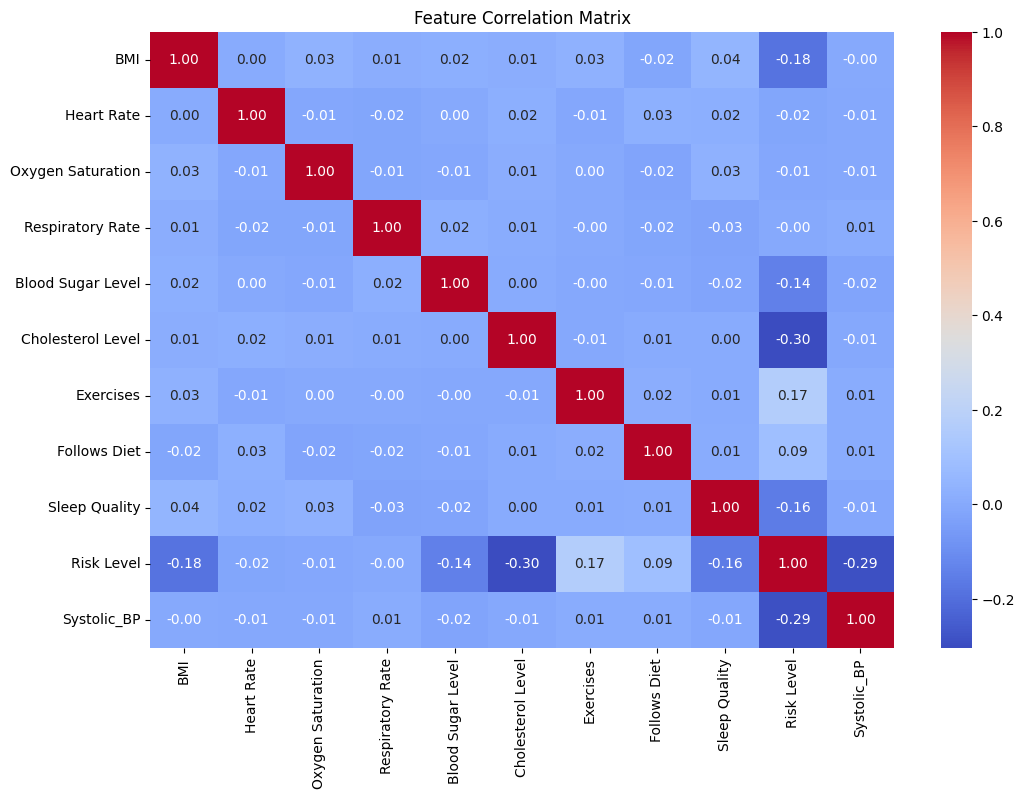

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## 3.2 Class Distribution

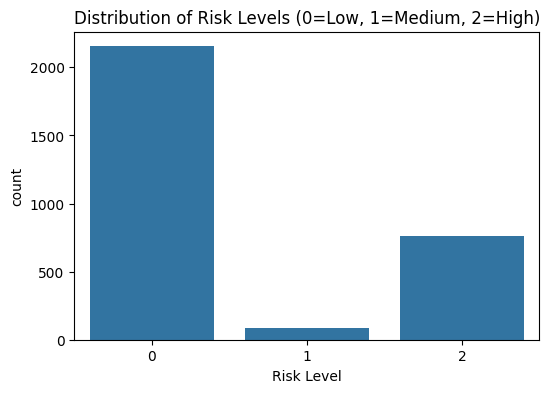

In [6]:
# clss ditribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk Level', data=df)
plt.title("Distribution of Risk Levels (0=Low, 1=Medium, 2=High)")
plt.show()


# 4. Train-Test Split

In [8]:

X = df.drop(columns=['Risk Level'])
y = df['Risk Level']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.1 Standardization

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

Training set: (2400, 10), Test set: (600, 10)


## 4.2 Handling Class Imbalance

In [10]:
print("Before SMOTE:", np.unique(y_train, return_counts=True))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", np.unique(y_train_smote, return_counts=True))


Before SMOTE: (array([0, 1, 2]), array([1741,   67,  592], dtype=int64))
After SMOTE: (array([0, 1, 2]), array([1741, 1741, 1741], dtype=int64))


# 5. Function for models

In [11]:
def evaluate_model(model, X_test, y_test):
    """Generate evaluation metrics and plots"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    # Classification report
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.show()
    
    # ROC AUC (for multiclass)
    if y_proba is not None:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), 
                               y_proba, multi_class='ovr')
        print(f"ROC AUC (OvR): {roc_auc:.4f}")


# 6. Model Training

## 6.1 Logistic Regression

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       413
           1       0.21      0.94      0.34        16
           2       0.50      0.46      0.48       171

    accuracy                           0.68       600
   macro avg       0.52      0.72      0.54       600
weighted avg       0.73      0.68      0.70       600



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


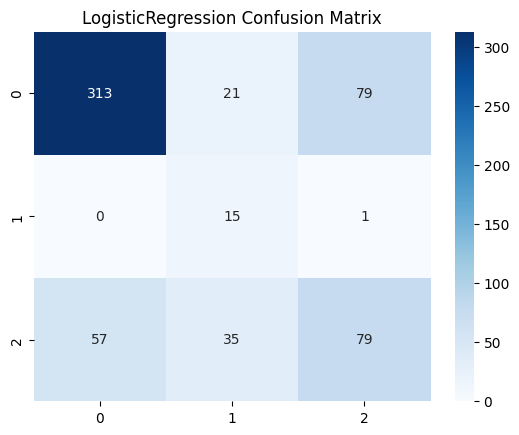

ROC AUC (OvR): 0.8356


In [13]:
from sklearn.preprocessing import label_binarize

lr = LogisticRegression(max_iter=1000, multi_class='ovr')
lr.fit(X_train_smote, y_train_smote)
evaluate_model(lr, X_test_scaled, y_test)


## 6.2 Random Forest

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       413
           1       1.00      0.88      0.93        16
           2       0.99      0.97      0.98       171

    accuracy                           0.99       600
   macro avg       0.99      0.95      0.97       600
weighted avg       0.99      0.99      0.99       600



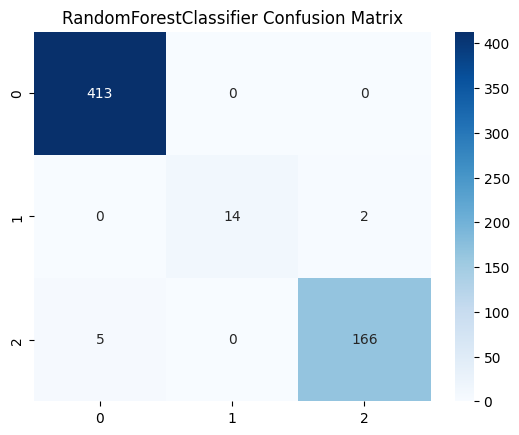

ROC AUC (OvR): 0.9967


In [14]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
evaluate_model(rf, X_test_scaled, y_test)

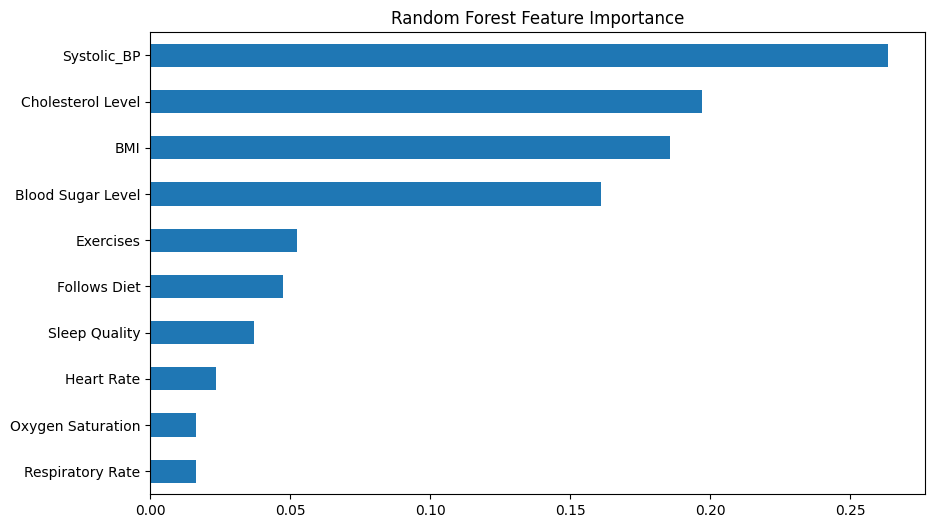

In [15]:
plt.figure(figsize=(10, 6))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot.barh()
plt.title("Random Forest Feature Importance")
plt.show()

## 6.3 XGBclassifier

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.88      0.93        16
           2       0.99      1.00      0.99       171

    accuracy                           1.00       600
   macro avg       1.00      0.96      0.98       600
weighted avg       1.00      1.00      1.00       600



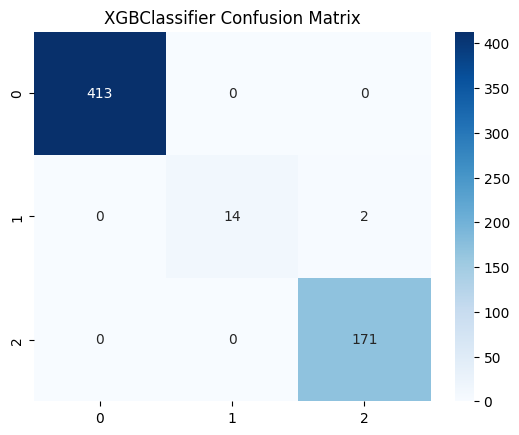

ROC AUC (OvR): 0.9973


In [16]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_smote, y_train_smote)
evaluate_model(xgb, X_test_scaled, y_test)

## 6.4 Neural Network

In [17]:
y_train_onehot = to_categorical(y_train_smote)
y_test_onehot = to_categorical(y_test)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train
history = model.fit(X_train_smote, y_train_onehot, 
                    epochs=50, batch_size=32,
                    validation_split=0.2, 
                    verbose=1)


c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5862 - loss: 0.9102 - val_accuracy: 0.1349 - val_loss: 1.3889
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8313 - loss: 0.4385 - val_accuracy: 0.4077 - val_loss: 1.0750
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8597 - loss: 0.3453 - val_accuracy: 0.4871 - val_loss: 0.9279
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8867 - loss: 0.2971 - val_accuracy: 0.6325 - val_loss: 0.7260
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9022 - loss: 0.2534 - val_accuracy: 0.6536 - val_loss: 0.6634
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8985 - loss: 0.2472 - val_accuracy: 0.6890 - val_loss: 0.6139
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9068 - loss: 0.2165 - val_accuracy: 0.7244 - val_loss: 0.5854
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.2102 - val_accuracy: 0.

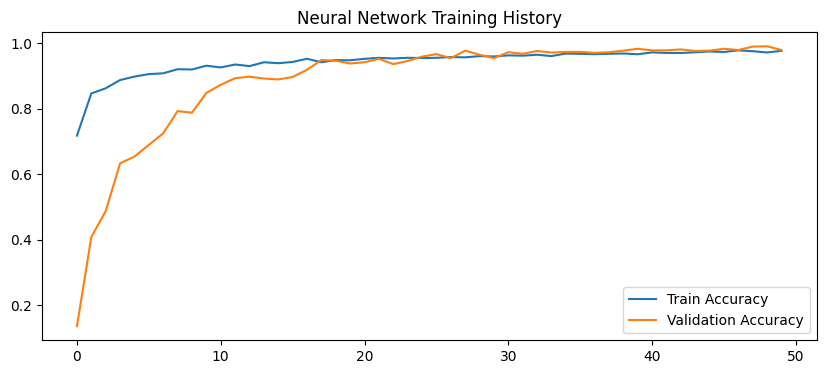

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Neural Network Training History")
plt.legend()
plt.show()

# 7. Grid Search

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       413
           1       1.00      0.88      0.93        16
           2       0.99      0.98      0.99       171

    accuracy                           0.99       600
   macro avg       0.99      0.95      0.97       600
weighted avg       0.99      0.99      0.99       600



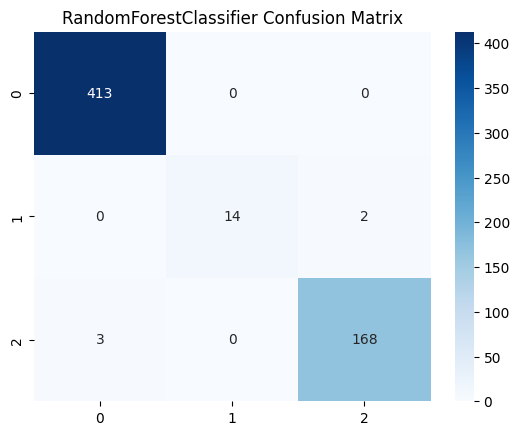

ROC AUC (OvR): 0.9965


In [19]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                      param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)
evaluate_model(best_rf, X_test_scaled, y_test)

# 8. Saving the Model

In [22]:
joblib.dump(best_rf, './models/random_forest_model.pkl')
joblib.dump(xgb, './models/xgboost_model.pkl')
joblib.dump(scaler, './models/scaler.pkl')
model.save('./models/neural_network_model.h5')



# <span style="color:red">Monitoring (Do not touch util deployement is considered)</span>

## Intialize the Monitoring and Logging



In [ ]:
logging.basicConfig(filename='predictions.log', level=logging.INFO)
from alibi_detect import KSDrift

## Drift Detection

In [ ]:
drift_detector = KSDrift(X_train_scaled, p_val=0.05)
drift = drift_detector.predict(X_test_scaled)
print("Data Drift Detected:", drift['data']['is_drift'])

# Make Predictions

## Load models

In [ ]:
loaded_rf = joblib.load('random_forest_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# ye example hai aise data feed hoga sare seperated values sequence me labels ko dikha rahe hain
# new_data = pd.DataFrame([[
#     28.5, 72, 98, 19, 125, 199, 1, 0, 1  # Example feature values
# ]], columns=X.columns)

## Preprocessing & Prediction

In [ ]:
new_data_scaled = loaded_scaler.transform(new_data)
prediction = loaded_rf.predict(new_data_scaled)
print(f"Predicted Risk Level: {prediction[0]} (0=Low, 1=Medium, 2=High)")


logging.info(f"Prediction: {prediction}, Timestamp: {pd.Timestamp.now()}")
